## Generate Flood Inundation Maps using XFIM

**Authors**: Anthony Castronova (acastronova@cuahsi.org), Irene Garousi-Nejad (igarousi@cuahsi.org)  <br>
**Last updated**: Mar 26, 2024

This notebook demonstrates how to generate flood inundation maps using the methodology and datasets defined by https://github.com/noAA-OWP/inundation-mapping. All data used in this notebook are publicly acessible via Amazon AWS. 

This work was funded by:

 <img src="https://www.hydroshare.org/resource/dc269e23ff494a06b7372bc6034a5de2/data/contents/v3-SNOW/logo-img/CUAHSI-4-color-logo_with_URL.png" width="300" height="300" style="padding-right:50px"> <img src="https://www.hydroshare.org/resource/dc269e23ff494a06b7372bc6034a5de2/data/contents/v3-SNOW/logo-img/CIROHLogo_200x200.png" width="100" height="20">    

`Xfim` is a utility library created by CUAHSI to make it easier to generate flood inundation maps using the methodology and data products published by the NOAA OWP.

In [1]:
import pandas
import hvplot.xarray
from nwm_utils.fim import xfim
from datetime import datetime, timedelta
from nwm_utils.retrospective import v3 as retrov3

In [2]:
reach_id = 946010122
st_date = '2000-03-01'
end_date = '2020-06-30'

In [3]:
%%time 
df = retrov3.get_nwm_q(reach_id, st_date, end_date , f'{reach_id}-qout.csv')
#df = pandas.read_csv(f'{reach_id}-qout.csv',parse_dates=['time'])

df

CPU times: user 256 ms, sys: 42.9 ms, total: 299 ms
Wall time: 300 ms


,time,elevation,feature_id,gage_id,latitude,longitude,order,streamflow_m3 s-1
0,2000-03-01 00:00:00,1851.01,946010122,b' ',42.24629,-111.08333,4,0.18
1,2000-03-01 01:00:00,1851.01,946010122,b' ',42.24629,-111.08333,4,0.18
2,2000-03-01 02:00:00,1851.01,946010122,b' ',42.24629,-111.08333,4,0.18
3,2000-03-01 03:00:00,1851.01,946010122,b' ',42.24629,-111.08333,4,0.18
4,2000-03-01 04:00:00,1851.01,946010122,b' ',42.24629,-111.08333,4,0.18
...,...,...,...,...,...,...,...,...
178220,2020-06-29 20:00:00,1851.01,946010122,b' ',42.24629,-111.08333,4,1.84
178221,2020-06-29 21:00:00,1851.01,946010122,b' ',42.24629,-111.08333,4,1.84
178222,2020-06-29 22:00:00,1851.01,946010122,b' ',42.24629,-111.08333,4,1.84
178223,2020-06-29 23:00:00,1851.01,946010122,b' ',42.24629,-111.08333,4,1.84


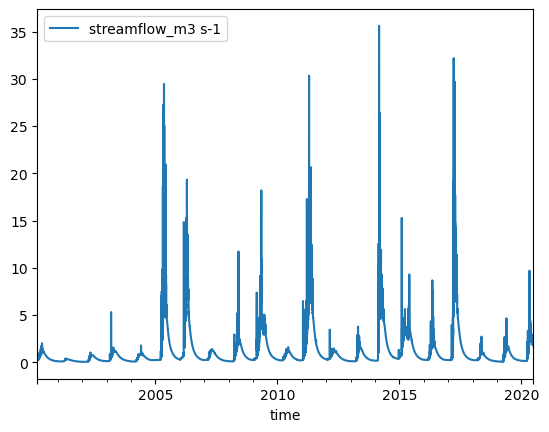

In [4]:
df.plot(x='time', y='streamflow_m3 s-1');

Determine the day with highest flow rate.

In [39]:
all_flows = df.groupby(df.time.dt.date).max()[['streamflow_m3 s-1']].values
all_times = df.groupby(df.time.dt.date).max().index.values

# get index of max flow rate
idx = all_flows.argmax()
flow_max = all_flows[idx]
time_max = all_times[idx]

print(f'Maximum Flow is {flow_max[0]} cms at {time_max}, index = {idx}')

Maximum Flow is 35.609999204054475 cms at 2014-03-02, index = 5114


Generate a series of FIMs for times surrounding the maximum flow rate.

In [40]:

st = pandas.to_datetime(all_times[idx] - timedelta(days=1))
et = pandas.to_datetime(all_times[idx] + timedelta(days=1))
dat = df.loc[(df.time >= st) & (df.time <= et)]

# get arrays of flow rates and times for this period
flows = dat['streamflow_m3 s-1'].values
times = dat['time'].values

Compute FIM for each timestep.

In [41]:
res = xfim.generate_fim_through_time(reach_id, times, flows)

Computing FIM: NHD+ 946010122 at 2014-03-01T00:00:00.000000000
Computing FIM: NHD+ 946010122 at 2014-03-01T01:00:00.000000000
Computing FIM: NHD+ 946010122 at 2014-03-01T02:00:00.000000000
Computing FIM: NHD+ 946010122 at 2014-03-01T03:00:00.000000000
Computing FIM: NHD+ 946010122 at 2014-03-01T04:00:00.000000000
Computing FIM: NHD+ 946010122 at 2014-03-01T05:00:00.000000000
Computing FIM: NHD+ 946010122 at 2014-03-01T06:00:00.000000000
Computing FIM: NHD+ 946010122 at 2014-03-01T07:00:00.000000000
Computing FIM: NHD+ 946010122 at 2014-03-01T08:00:00.000000000
Computing FIM: NHD+ 946010122 at 2014-03-01T09:00:00.000000000
Computing FIM: NHD+ 946010122 at 2014-03-01T10:00:00.000000000
Computing FIM: NHD+ 946010122 at 2014-03-01T11:00:00.000000000
Computing FIM: NHD+ 946010122 at 2014-03-01T12:00:00.000000000
Computing FIM: NHD+ 946010122 at 2014-03-01T13:00:00.000000000
Computing FIM: NHD+ 946010122 at 2014-03-01T14:00:00.000000000
Computing FIM: NHD+ 946010122 at 2014-03-01T15:00:00.00

Plot an animation of this flood event.

In [42]:
maximum_fim = res.fim_extent.max()

res.fim_extent.hvplot(
    invert=True,
    groupby='time',
    clim=(0, maximum_fim),
    widget_type='scrubber',
    widget_location='bottom',
    width=700,
    height=600)

Column
    [0] HoloViews(DynamicMap, height=600, sizing_mode='fixed', widget_location='bottom', widget_type='scrubber', width=700)
    [1] WidgetBox(align=('center', 'end'))
        [0] Player(end=48, width=550)